# 🧪 Lapatinib Model Comparison with MLflow
This notebook compares multiple ML models using cross-validation and logs results to MLflow.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import mlflow
import mlflow.sklearn
import os

In [5]:
# Load data
filtered_gene_expr_binary = pd.read_csv("filtered_gene_expr_binary.csv")
filtered_gene_expr_binary = filtered_gene_expr_binary.set_index(filtered_gene_expr_binary.columns[0])
X = filtered_gene_expr_binary.drop(columns=["RESPONSE"])  
y = filtered_gene_expr_binary["RESPONSE"].map({"Resistant": 0, "Sensitive": 1})    

In [7]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Logistic Regression (L1)": LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

In [11]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
import mlflow
import os
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd

mlflow.set_tracking_uri("file:///C:/Users/dimim/mlruns")
mlflow.set_experiment("Lapatinib_Model_Comparison_2")
os.makedirs("artifacts", exist_ok=True)

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        
        auc = None
        y_proba = None

       
        if hasattr(model, "predict_proba"):
            try:
                y_proba = model.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, y_proba)
                mlflow.log_metric("ROC_AUC", auc)
            except:
                mlflow.log_metric("ROC_AUC", -1)
        else:
            mlflow.log_metric("ROC_AUC", -1)

        # Other metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("F1_score", f1)

       
        scorers = ['accuracy', 'f1']
        if hasattr(model, "predict_proba"):
            scorers.append('roc_auc')

        cv_scores = cross_validate(model, X_scaled, y, scoring=scorers, cv=cv)

        mlflow.log_metric("CV_Accuracy_Mean", np.mean(cv_scores["test_accuracy"]))
        mlflow.log_metric("CV_F1_Mean", np.mean(cv_scores["test_f1"]))
        if 'test_roc_auc' in cv_scores:
            mlflow.log_metric("CV_ROC_AUC_Mean", np.mean(cv_scores["test_roc_auc"]))
        else:
            mlflow.log_metric("CV_ROC_AUC_Mean", -1)

        # Log parameters
        mlflow.log_params(model.get_params())

        # Log model
        mlflow.sklearn.log_model(model, "model")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(cm, index=["Actual_0", "Actual_1"], columns=["Pred_0", "Pred_1"])
        cm_path = f"artifacts/{name.replace(' ', '_')}_confusion_matrix.csv"
        cm_df.to_csv(cm_path)
        mlflow.log_artifact(cm_path)

        # Feature importances
        if hasattr(model, "feature_importances_"):
            fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
            fi_path = f"artifacts/{name.replace(' ', '_')}_feature_importances.csv"
            fi.to_csv(fi_path)
            mlflow.log_artifact(fi_path)


2025/07/11 10:56:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 10:56:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 10:56:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 10:56:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 10:56:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 10:56:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 10:56:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use 

In [21]:
import mlflow
import pandas as pd

mlflow.set_tracking_uri("file:///C:/Users/dimim/mlruns")
experiment_name = "Lapatinib_Model_Comparison_2"

client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment.experiment_id)

# Extract relevant metrics
metrics_list = ['Accuracy', 'F1_score', 'ROC_AUC', 'CV_Accuracy_Mean', 'CV_F1_Mean', 'CV_ROC_AUC_Mean']
data = []

for run in runs:
    metrics = run.data.metrics
    entry = {
        'Run_Name': run.data.tags.get("mlflow.runName", run.info.run_id)
    }
    for metric in metrics_list:
        entry[metric] = metrics.get(metric, None)
    data.append(entry)

df_metrics = pd.DataFrame(data)
df_metrics = df_metrics.set_index('Run_Name')
df_metrics = df_metrics.sort_values(by='Accuracy', ascending=False)
df_metrics


,Accuracy,F1_score,ROC_AUC,CV_Accuracy_Mean,CV_F1_Mean,CV_ROC_AUC_Mean
Run_Name,,,,,,
SVM,0.732143,0.680851,-1.000000,0.788117,0.756388,-1.000000
Logistic Regression (L1),0.732143,0.693878,0.767949,0.734545,0.723185,0.850493
XGBoost,0.714286,0.652174,0.752564,0.705974,0.669400,0.802105
Random Forest,0.678571,0.608696,0.758974,0.763182,0.717296,0.845688
Logistic Regression,0.678571,0.625000,0.800000,0.766623,0.745225,0.868215


<Figure size 1200x600 with 0 Axes>

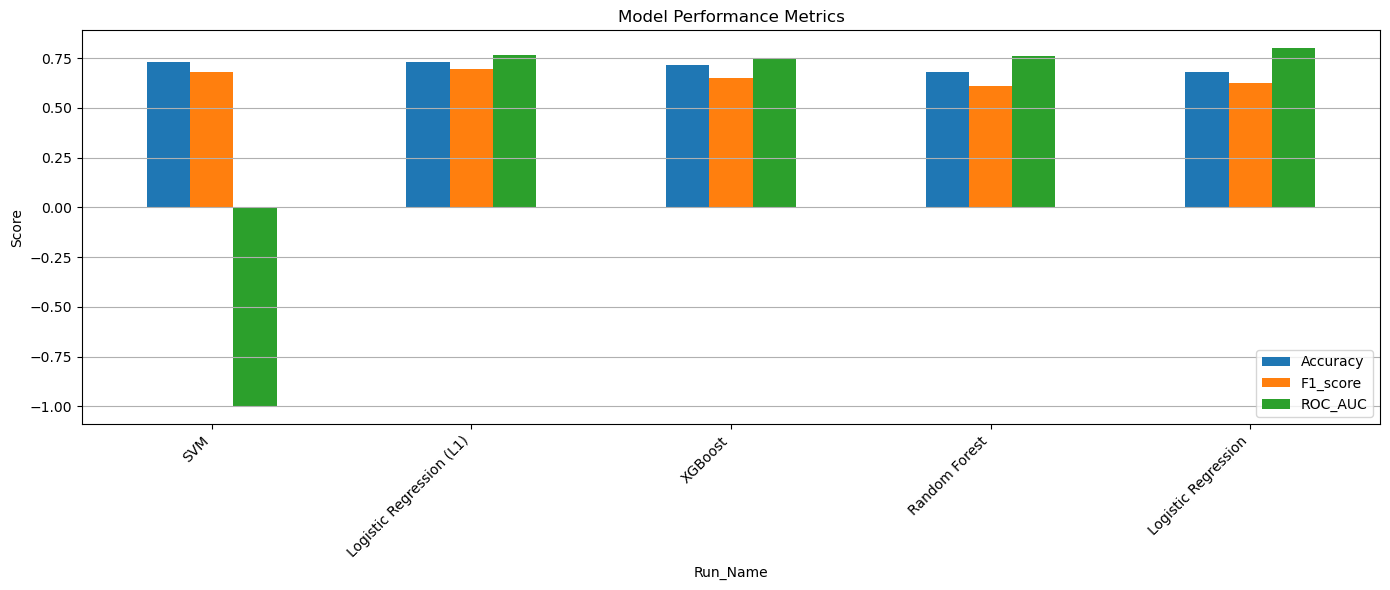

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


plot_metrics = ['Accuracy', 'F1_score', 'ROC_AUC']

plt.figure(figsize=(12, 6))
df_metrics[plot_metrics].plot(kind='bar', figsize=(14, 6))
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


<Figure size 1200x600 with 0 Axes>

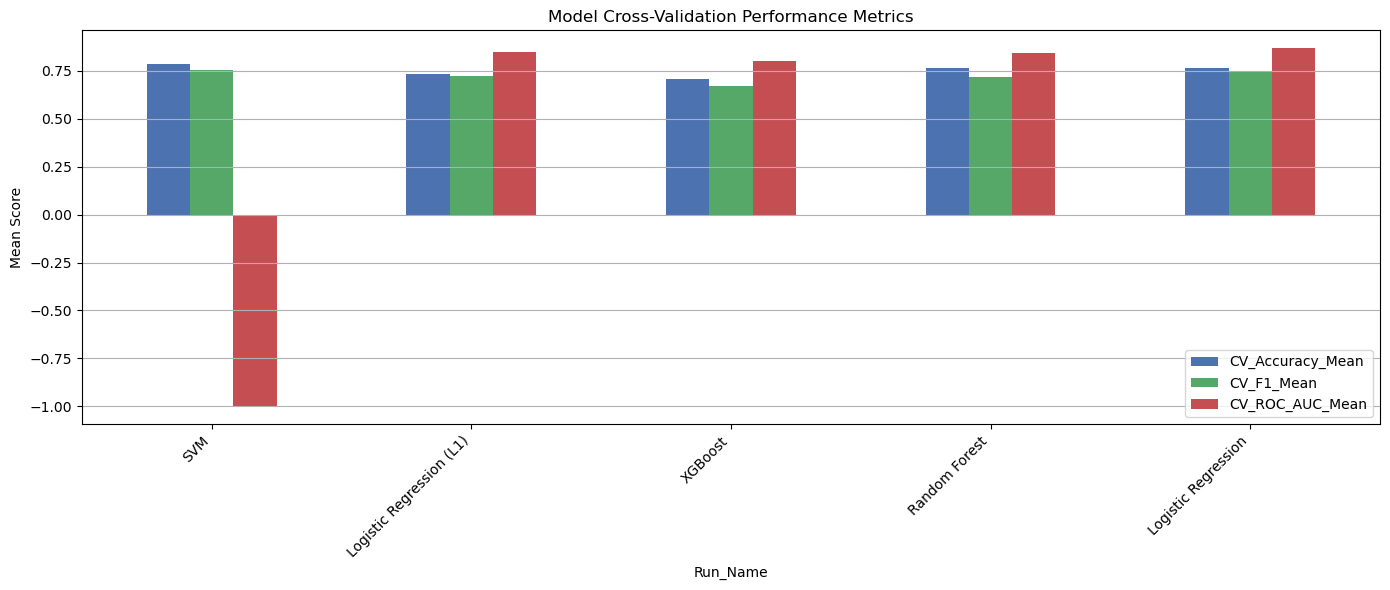

In [24]:
cv_metrics = ['CV_Accuracy_Mean', 'CV_F1_Mean', 'CV_ROC_AUC_Mean']

plt.figure(figsize=(12, 6))
df_metrics[cv_metrics].plot(kind='bar', figsize=(14, 6), color=['#4c72b0', '#55a868', '#c44e52'])
plt.title("Model Cross-Validation Performance Metrics")
plt.ylabel("Mean Score")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [26]:
df_metrics["Error_Rate"] = 1 - df_metrics["Accuracy"]
df_metrics["CV_Error_Rate"] = 1 - df_metrics["CV_Accuracy_Mean"]


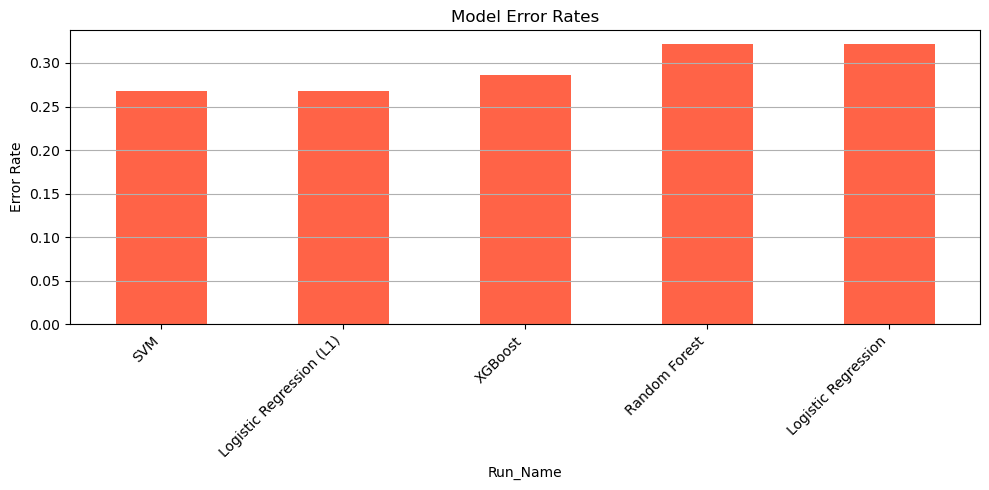

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
df_metrics["Error_Rate"].plot(kind='bar', color='tomato')
plt.title("Model Error Rates")
plt.ylabel("Error Rate")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
